In [1]:
print("""
@Title: Using the Keras Preprocessing API
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-09-09 21:35:23
@Description: 文件的代码有问题，运行的结果匪夷所思
""")


@Title: Using the Keras Preprocessing API
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-09-09 21:35:23
@Description: 



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences, skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import text_to_word_sequence, one_hot, hashing_trick, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Sequence preprocessing

### Time series generator

In [3]:
series = np.array([i for i in range(10)])
series

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We want to predict the next value from the last five lag observations. So, we'll define a generator with the length argument set to 5. This argument specifies the length of the output sequences in a number of timesteps:

In [4]:
generator = TimeseriesGenerator(data=series,
                                targets=series,
                                length=5,
                                batch_size=1,
                                shuffle=False,
                                reverse=False)

In [5]:
print("Samples: %d" % len(generator))

Samples: 5


Then, we'll display the inputs and output of each sample and check that the data is well prepared:

In [6]:
for i in range(len(generator)):
    x, y = generator[i]
    print("%s = > %s" % (x, y))

[[0 1 2 3 4]] = > [5]
[[1 2 3 4 5]] = > [6]
[[2 3 4 5 6]] = > [7]
[[3 4 5 6 7]] = > [8]
[[4 5 6 7 8]] = > [9]


In [16]:
model = Sequential()
model.add(Dense(10, activation="relu", input_dim=5))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [18]:
model.fit(generator, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 2ms/step - loss: 33.8480
Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 31.1212
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 28.5850
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 26.6716
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 24.1365
Epoch 6/10
5/5 [==============================] - 0s 0s/step - loss: 22.2586
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 20.4561
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 18.3756
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 16.9302
Epoch 10/10
5/5 [==============================] - 0s 5ms/step - loss: 15.3195


### Padding sequences

Sequences shorter than the defined sequence length are padded with values at the end (by default) or the beginning of each sequence. Otherwise, if the sequence is greater than the desired length, the sequence is truncated.

In [19]:
sentences = [["What", "do", "you", "like", "?"],
             ["I", "like", "basket-ball", "!"],
             ["And", "you", "?"],
             ["I", "like", "coconut", "and", "apple"]]

In [31]:
text_set = set(np.concatenate(sentences))
# ✅
vocab_to_int = dict(zip(text_set, range(len(text_set))))
int_to_vocab = {vocab_to_int[word]: word for word in vocab_to_int.keys()}

In [35]:
encoded_sentences = []
for sentence in sentences:
    encoded_sentence = [vocab_to_int[word] for word in sentence]
    encoded_sentences.append(encoded_sentence)
encoded_sentences

[[11, 5, 10, 8, 9], [1, 8, 6, 2], [0, 10, 9], [1, 8, 7, 3, 4]]

Now, we'll use the pad_sequences function to truncate and pad sequences to a common length easily. The pre-sequence padding is activated by default.

In [36]:
pad_sequences(encoded_sentences)

array([[11,  5, 10,  8,  9],
       [ 0,  1,  8,  6,  2],
       [ 0,  0,  0, 10,  9],
       [ 1,  8,  7,  3,  4]])

In [38]:
pad_sequences(encoded_sentences, maxlen=7)

array([[ 0,  0, 11,  5, 10,  8,  9],
       [ 0,  0,  0,  1,  8,  6,  2],
       [ 0,  0,  0,  0,  0, 10,  9],
       [ 0,  0,  1,  8,  7,  3,  4]])

In [39]:
pad_sequences(encoded_sentences, maxlen=3)

array([[10,  8,  9],
       [ 8,  6,  2],
       [ 0, 10,  9],
       [ 7,  3,  4]])

In [40]:
pad_sequences(encoded_sentences, maxlen=3, truncating="post")

array([[11,  5, 10],
       [ 1,  8,  6],
       [ 0, 10,  9],
       [ 1,  8,  7]])

### Skip-grams

In [89]:
sentence = "I like coconut and apple"
encoded_sentence = [vocab_to_int[word] for word in sentence.split()]
vocabulary_size = len(encoded_sentence)

In [90]:
pairs, labels = skipgrams(encoded_sentence,
                          vocabulary_size,
                          window_size=1)

In [103]:
for i in range(len(pairs)):
    print("({:s} , {:s}) -> {:d}".format(
          int_to_vocab[pairs[i][0]], 
          int_to_vocab[pairs[i][1]], 
          labels[i]))
# 这个感叹号是哪里来的❌

(like , and) -> 0
(I , I) -> 0
(like , apple) -> 0
(and , apple) -> 0
(I , like) -> 1
(and , coconut) -> 1
(like , coconut) -> 1
(and , apple) -> 0
(and , apple) -> 1
(coconut , !) -> 0
(coconut , and) -> 1
(apple , I) -> 0
(apple , and) -> 1
(coconut , !) -> 0
(coconut , like) -> 1
(like , I) -> 1


## Text preprocessing

### Split text to word sequence

Keras provides the `text_to_word_sequence` method, which transforms a sequence into a list of words or tokens.

In [106]:
sentence = "I like coconut , I like apple"
# 默认是按照空格分割
text_to_word_sequence(sentence, lower=False, filters=[])
# sentence.split(" ")
# sentence.lower().split(" ")

['i', 'like', 'coconut', ',', 'i', 'like', 'apple']

In [109]:
# filters 用来过滤一些字符，比如说标点符号
text_to_word_sequence(sentence, lower=True, filters=[','])

['i', 'like', 'coconut', 'i', 'like', 'apple']

### Tokenizer

In [120]:
sentences = [["What", "do", "you", "like", "?", "you"],
             ["I", "like", "basket-ball", "!"],
             ["And", "you", "?"],
             ["I", "like", "coconut", "and", "apple"]]

In [121]:
t = Tokenizer()
t.fit_on_texts(sentences)

In [122]:
t.word_counts

OrderedDict([('what', 1),
             ('do', 1),
             ('you', 3),
             ('like', 3),
             ('?', 2),
             ('i', 2),
             ('basket-ball', 1),
             ('!', 1),
             ('and', 2),
             ('coconut', 1),
             ('apple', 1)])

In [123]:
assert t.document_count == len(sentences)

In [124]:
t.word_index

{'you': 1,
 'like': 2,
 '?': 3,
 'i': 4,
 'and': 5,
 'what': 6,
 'do': 7,
 'basket-ball': 8,
 '!': 9,
 'coconut': 10,
 'apple': 11}

In [125]:
# 分词在几篇文档中出现
t.word_docs

defaultdict(int,
            {'what': 1,
             'do': 1,
             'like': 3,
             '?': 2,
             'you': 2,
             'basket-ball': 1,
             'i': 2,
             '!': 1,
             'and': 2,
             'apple': 1,
             'coconut': 1})

In [128]:
t.texts_to_matrix(sentences, mode='binary')
# 是否出现，基于计数

array([[0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.]])

In [129]:
t.texts_to_matrix(sentences, mode='count')
# 出现次数，基于计数

array([[0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.]])

In [130]:
t.texts_to_matrix(sentences, mode='tfidf')

array([[0.        , 1.43459998, 0.69314718, 0.84729786, 0.        ,
        0.        , 1.09861229, 1.09861229, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.69314718, 0.        , 0.84729786,
        0.        , 0.        , 0.        , 1.09861229, 1.09861229,
        0.        , 0.        ],
       [0.        , 0.84729786, 0.        , 0.84729786, 0.        ,
        0.84729786, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.69314718, 0.        , 0.84729786,
        0.84729786, 0.        , 0.        , 0.        , 0.        ,
        1.09861229, 1.09861229]])

In [132]:
t.texts_to_matrix(sentences, mode='freq')

array([[0.        , 0.33333333, 0.16666667, 0.16666667, 0.        ,
        0.        , 0.16666667, 0.16666667, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.25      , 0.        , 0.25      ,
        0.        , 0.        , 0.        , 0.25      , 0.25      ,
        0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.2       , 0.        , 0.2       ,
        0.2       , 0.        , 0.        , 0.        , 0.        ,
        0.2       , 0.2       ]])

## Image preprocessing

In [168]:
(X_cifar10_train, y_cifar10_train), (X_cifar10_test, y_cifar10_test) = tf.keras.datasets.cifar10.load_data()

In [169]:
X_cifar10_train = X_cifar10_train[:30_000]
y_cifar10_train = y_cifar10_train[:30_000]
# 只用前面三万张照片

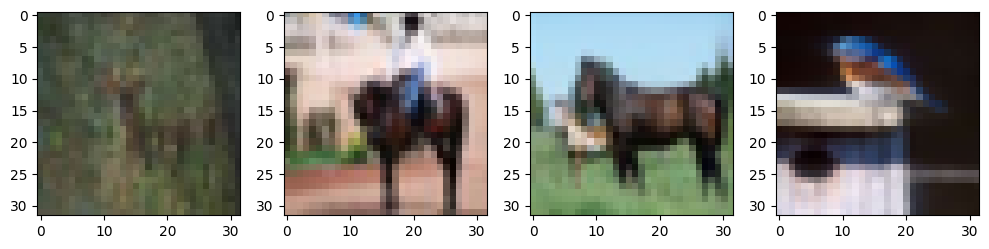

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
n_cols = 4
for i in range(n_cols):
    plt.subplot(1, n_cols, i + 1)
    plt.imshow(X_cifar10_train[i+10])
plt.tight_layout()
plt.show()

In [157]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
it = datagen.flow(X_cifar10_train[10:12], y_cifar10_train[10:12], batch_size=1)

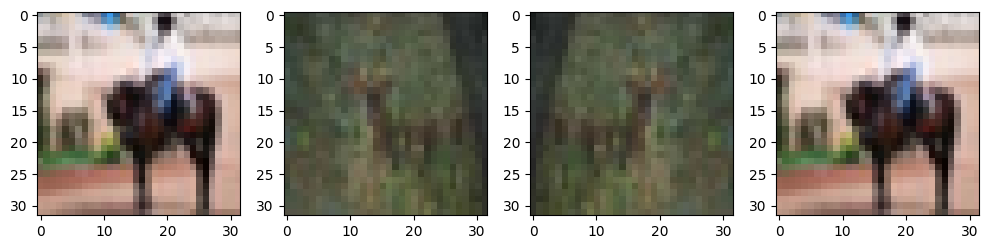

In [162]:
plt.figure(figsize=(10, 10))
for i in range(n_cols):
    plt.subplot(1, n_cols, i + 1)
    batch = it.next()
    image = tf.squeeze(batch[0])
    plt.imshow(np.uint8(image))
plt.tight_layout()
plt.show()

Now, we'll create an image data generator that applies a horizontal flip, a random rotation between 0 and 15, and a shift of 3 pixels on the width and on the height.

In [203]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                                                          rescale=1./255,
                                                          width_shift_range=3,
                                                          height_shift_range=3,
                                                          horizontal_flip=True)
# rescale 暂时不能确定其作用，但是这是可以正确运行的参数
# ❌

Create an iterator on the train dataset.

In [204]:
it = datagen.flow(X_cifar10_train, y_cifar10_train, batch_size=32)

In [205]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [206]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=.01),
              metrics=["accuracy"])

In [207]:
history = model.fit(it, 
                    epochs=3,
                    steps_per_epoch=len(X_cifar10_train) / 32,
                    validation_data=(X_cifar10_test, y_cifar10_test))

Epoch 1/3
937/937 [==============================] - 105s 109ms/step - loss: 2.0968 - accuracy: 0.2578 - val_loss: 300.3684 - val_accuracy: 0.4015
Epoch 2/3
937/937 [==============================] - 105s 112ms/step - loss: 1.8053 - accuracy: 0.1024 - val_loss: 279.3787 - val_accuracy: 0.3581
Epoch 3/3
937/937 [==============================] - 88s 94ms/step - loss: 1.6438 - accuracy: 0.0971 - val_loss: 220.0734 - val_accuracy: 0.2665
